## Introduction

Let's start by loading our dataset into a pandas DataFrame to get an overview of the data. After examining the dataset, we’ll prepare it for feature engineering and extraction. Following this, we’ll divide the data into training, validation, and test sets, and explore the training data to uncover patterns that can help guide our model’s learning.

In [24]:
import pandas as pd

nutrients = pd.read_csv("data/nutrients.csv")
food_nutrients = pd.read_csv("data/food_nutrients.csv")
food_train = pd.read_csv("data/food_train.csv")

## Food Nutrients Dataset

In [4]:
food_nutrients

,idx,nutrient_id,amount
0,1,1087,143.00
1,1,1089,5.14
2,1,1104,0.00
3,1,1162,0.00
4,1,1003,7.14
...,...,...,...
493049,35276,1104,0.00
493050,35276,1162,17.10
493051,35276,1253,0.00
493052,35276,1257,0.00


The "amount" column lacks significance without the serving units. This suggests that we need to combine data from the two datasets to make it meaningful.

In [5]:
food_nutrients.isna().any()

idx            False
nutrient_id    False
amount         False
dtype: bool

There're no missing values within the food_nutrients dataset

In [6]:
food_nutrients['nutrient_id'].nunique()

48

There are only 48 unique nutrients in the snacks dataset

It would be helpful to create a column for each nutrient and populate it with the corresponding amount in the food, with a default value of 0 indicating the absence of that nutrient. This approach will allow for an easier merge between the food_nutrients and snacks datasets.

In [7]:
food_nutrients_wide = food_nutrients.pivot_table(
index = ['idx'],
columns = ['nutrient_id'],
values = ['amount'],
fill_value= 0).droplevel(0,axis = 1)


food_nutrients_wide

nutrient_id,1003,1004,1005,1008,1009,1018,1056,1062,1072,1078,...,1178,1185,1186,1235,1253,1257,1258,1292,1293,2000
idx,,,,,,,,,,,,,,,,,,,,,
1,7.14,35.71,53.57,536,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,18,0.0,25.00,0.0,0.0,42.86
2,2.63,15.79,68.42,421,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,26,0.0,6.58,0.0,0.0,42.11
3,3.33,15.00,70.00,433,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,17,0.0,6.67,0.0,0.0,43.33
4,5.00,22.50,67.50,475,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,0,0.0,17.50,0.0,0.0,47.50
5,7.50,42.50,47.50,600,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,12,0.0,17.50,0.0,0.0,40.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35272,10.71,7.14,71.43,393,0.0,0,0,0,0,0,...,0.0,0.0,0,14.3,0,0.0,0.00,0.0,0.0,17.86
35273,3.23,0.00,77.42,323,0.0,0,0,0,0,0,...,0.0,0.0,0,41.9,0,0.0,0.00,0.0,0.0,41.94
35274,7.14,32.14,53.57,536,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,0,0.0,3.57,0.0,0.0,7.14


In [8]:
(food_nutrients_wide > 0).mean().sort_values().head(10)


nutrient_id
1018    0.000000
1009    0.000028
1062    0.000028
1102    0.000057
1176    0.000057
1078    0.000057
1109    0.000340
1056    0.000397
1186    0.000595
1072    0.000652
dtype: float64

Some nutrients are very rare.
We'll keep these nutrients in the dataset for now to see if they prove useful for our model. This could be because some nutrients are only present in certain food categories.

After examining the nutrient distributions among the snacks, we noticed that some nutrients frequently have positive values, while others do not. Additionally, some nutrients are correlated with each other. We'll determine their usefulness later and decide the threshold for eliminating certain nutrients.

## Nutrients Dataset

In [9]:
nutrients

,nutrient_id,name,unit_name
0,1002,Nitrogen,G
1,1003,Protein,G
2,1004,Total lipid (fat),G
3,1005,"Carbohydrate, by difference",G
4,1007,Ash,G
...,...,...,...
230,2026,20:2 c,G
231,2028,trans-beta-Carotene,UG
232,2029,trans-Lycopene,UG
233,2032,"Cryptoxanthin, alpha",UG


In [10]:
nutrients.isna().any().any()

False

No missing values in nutrients

There is one duplicated name:

In [11]:
nutrients[nutrients['name'].duplicated(keep = False)].sort_values('name')

,nutrient_id,name,unit_name
5,1008,Energy,KCAL
23,1062,Energy,kJ


It may be helpful to later merge these two nutrients into one, as they represent the same thing. We can achieve this by scaling them with the appropriate conversion factor (KCAL -> KJ).

Before applying machine learning algorithms, data preprocessing is typically required, including feature scaling. The unit_name variable becomes redundant since it’s simply a string representation of a scaling factor. We'll append the unit name as a suffix to the column name and then drop the unit_name column.

In [12]:
nutrients_v2 = nutrients.copy()

nutrients_v2.loc[:, "name"] = (
    nutrients.apply(lambda row: f'{row["name"]}__({row["unit_name"]})', axis=1)
    .str.replace(" ", "_")
    .str.replace(",", "")
    .str.lower()
)
nutrients_v2.drop(columns=["unit_name"], inplace=True)
nutrients_v2.set_index("nutrient_id", inplace=True)

In [13]:
nutrients_v2

,name
nutrient_id,
1002,nitrogen__(g)
1003,protein__(g)
1004,total_lipid_(fat)__(g)
1005,carbohydrate_by_difference__(g)
1007,ash__(g)
...,...
2026,20:2_c__(g)
2028,trans-beta-carotene__(ug)
2029,trans-lycopene__(ug)


In [14]:
food_nutrients_merged = food_nutrients_wide.rename(mapper = nutrients_v2["name"],axis = 1)
food_nutrients_merged.head()

nutrient_id,protein__(g),total_lipid_(fat)__(g),carbohydrate_by_difference__(g),energy__(kcal),starch__(g),alcohol_ethyl__(g),sorbitol__(g),energy__(kj),carbohydrate_other__(g),xylitol__(g),...,vitamin_b-12__(ug),vitamin_k_(phylloquinone)__(ug),folic_acid__(ug),sugars_added__(g),cholesterol__(mg),fatty_acids_total_trans__(g),fatty_acids_total_saturated__(g),fatty_acids_total_monounsaturated__(g),fatty_acids_total_polyunsaturated__(g),sugars_total_including_nlea__(g)
idx,,,,,,,,,,,,,,,,,,,,,
1,7.14,35.71,53.57,536,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,18,0.0,25.00,0.0,0.0,42.86
2,2.63,15.79,68.42,421,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,26,0.0,6.58,0.0,0.0,42.11
3,3.33,15.00,70.00,433,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,17,0.0,6.67,0.0,0.0,43.33
4,5.00,22.50,67.50,475,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,0,0.0,17.50,0.0,0.0,47.50
5,7.50,42.50,47.50,600,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,12,0.0,17.50,0.0,0.0,40.00


It may be reasonable to drop infrequent nutrients later, as they might not contribute much to the classification task. Let’s start by identifying the most infrequent nutrients:

In [15]:
(food_nutrients_merged > 0).sum().sort_values().to_frame().rename(
    columns={0:  "frequency"}
).head()

,frequency
nutrient_id,
alcohol_ethyl__(g),0
starch__(g),1
energy__(kj),1
molybdenum_mo__(ug),2
biotin__(ug),2


In [28]:
food_nutrients_merged.to_csv("data/food_nutrients_merged.csv")

In [17]:
food_train["category"] = food_train["category"].apply(lambda x: x.split('_')[0]) # for readability

In [18]:
from sklearn.model_selection import train_test_split


features_df = food_train.drop("category", axis=1)
labels_df = food_train["category"]

X_train, X_val_test, y_train, y_val_test = train_test_split(
    features_df, labels_df, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.25, random_state=42
)

X_train["y"] = y_train


In [20]:
X_train.isna().sum().sort_values(ascending=False)

ingredients                   30
household_serving_fulltext    10
idx                            0
brand                          0
description                    0
serving_size                   0
serving_size_unit              0
y                              0
dtype: int64

In [21]:
X_train[X_train["ingredients"].isna()]["y"].value_counts(
    normalize=True
).to_frame().rename(columns={"y": "rate"})

,rate
popcorn,0.600000
cakes,0.166667
candy,0.100000
cookies,0.066667
chips,0.033333
chocolate,0.033333


In [22]:
from helpers.preprocess import FillNA

FillNA().fit_transform(X=X_train)

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,y
23212,25784,"ahold usa, inc.",fudge brownie bites,"sugar, bleached wheat flour, soybean oil, wate...",28.0,g,1 onz,cakes
22158,24607,casa cardenas,vanilla cream wafers,"filling (sugar, vegetable shortening (may cont...",30.0,g,4 pieces,cookies
1703,1898,"meijer, inc.","markets of meijer, plain cake donut holes","enriched wheat flour (flour, niacin, reduced i...",54.0,g,4 holes,cakes
20886,23191,"mccormick & company, inc.","kitkat, crisp wafers in milk chocolate",sugar; wheat flour; nonfat milk; cocoa butter;...,42.0,g,1 four-piece bar,candy
18703,20739,tasty baking company,"tastykake, sponge cakes krimpets, orange cream...","sugar, enriched bleached flour (wheat flour, n...",67.0,g,2 cakes/1 pkg,cakes
...,...,...,...,...,...,...,...,...
29802,33105,first street,chocolate fudge brownies,"sugar, enriched wheat flour bleached (flour, n...",85.0,g,3 onz,cakes
5390,6019,smart & final iris corporation,"first street, patriotic frosted sugar sugar co...","sugar, enriched bleached wheat flour (flour, n...",38.0,g,1 cookie,cookies
860,960,el ranchero food products,"el romchero, tortilla chips","corn, line and corn oil.",39.0,g,1.4 onz,chips
15795,17524,"nuts about granola, llc",granola,"sunflower seeds, almonds, date sugar (dates), ...",28.0,g,0.25 cup,cookies


Next, we'll merge the snacks dataset with the food_nutrients_merged dataset using the food_id column as the key to join both datasets.

In [29]:
from helpers.preprocess import MergeWithFoodNutrients

X_train = MergeWithFoodNutrients().fit_transform(X=X_train)
X_train

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,y,protein__(g),total_lipid_(fat)__(g),...,vitamin_b-12__(ug),vitamin_k_(phylloquinone)__(ug),folic_acid__(ug),sugars_added__(g),cholesterol__(mg),fatty_acids_total_trans__(g),fatty_acids_total_saturated__(g),fatty_acids_total_monounsaturated__(g),fatty_acids_total_polyunsaturated__(g),sugars_total_including_nlea__(g)
23212,25784,"ahold usa, inc.",fudge brownie bites,"sugar, bleached wheat flour, soybean oil, wate...",28.0,g,1 onz,cakes,3.57,21.43,...,0.0,0.0,0,0.0,0,0.0,3.57,8.93,8.93,39.29
22158,24607,casa cardenas,vanilla cream wafers,"filling (sugar, vegetable shortening (may cont...",30.0,g,4 pieces,cookies,3.33,30.00,...,0.0,0.0,0,0.0,0,0.0,15.00,0.00,0.00,36.67
1703,1898,"meijer, inc.","markets of meijer, plain cake donut holes","enriched wheat flour (flour, niacin, reduced i...",54.0,g,4 holes,cakes,5.56,22.22,...,0.0,0.0,0,0.0,37,0.0,8.33,0.00,0.00,14.81
20886,23191,"mccormick & company, inc.","kitkat, crisp wafers in milk chocolate",sugar; wheat flour; nonfat milk; cocoa butter;...,42.0,g,1 four-piece bar,candy,7.14,26.19,...,0.0,0.0,0,0.0,12,0.0,16.67,0.00,0.00,50.00
18703,20739,tasty baking company,"tastykake, sponge cakes krimpets, orange cream...","sugar, enriched bleached flour (wheat flour, n...",67.0,g,2 cakes/1 pkg,cakes,2.99,13.43,...,0.0,0.0,0,0.0,75,0.0,4.48,3.73,3.73,44.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,33105,first street,chocolate fudge brownies,"sugar, enriched wheat flour bleached (flour, n...",85.0,g,3 onz,cakes,3.53,21.18,...,0.0,0.0,0,0.0,0,0.0,4.12,0.00,0.00,35.29
5390,6019,smart & final iris corporation,"first street, patriotic frosted sugar sugar co...","sugar, enriched bleached wheat flour (flour, n...",38.0,g,1 cookie,cookies,2.63,13.16,...,0.0,0.0,0,0.0,13,0.0,2.63,0.00,0.00,42.11
860,960,el ranchero food products,"el romchero, tortilla chips","corn, line and corn oil.",39.0,g,1.4 onz,chips,5.13,23.08,...,0.0,0.0,0,0.0,0,0.0,2.56,0.00,0.00,0.00
15795,17524,"nuts about granola, llc",granola,"sunflower seeds, almonds, date sugar (dates), ...",28.0,g,0.25 cup,cookies,14.29,25.00,...,0.0,0.0,0,0.0,0,0.0,5.36,0.00,0.00,10.71


We now have a dataset containing 55 features, combining information from all three tabular datasets. Let's dive deeper and perform further analysis on the data.

## Ingredients

The ingredients column is particularly interesting, as it can be seen as a nested column. Some entries contain a list of ingredients, while others contain only a single ingredient. We'll need to preprocess this column before it can be utilized for training.

In [31]:
X_train["ingredients"].head()


23212    sugar, bleached wheat flour, soybean oil, wate...
22158    filling (sugar, vegetable shortening (may cont...
1703     enriched wheat flour (flour, niacin, reduced i...
20886    sugar; wheat flour; nonfat milk; cocoa butter;...
18703    sugar, enriched bleached flour (wheat flour, n...
Name: ingredients, dtype: object

It's important to note that the data is noisy and includes typos in a small percentage of the entries:

In [32]:
from collections import Counter

ingredients_example = X_train.loc[18201, "ingredients"]
chars_counter = Counter(ingredients_example)

chars_counter["("] == chars_counter[")"]

False

First, we will remove the text that appears between parentheses () and square brackets []:

In [33]:
from helpers.preprocess import CleanAndListifyIngredients

CleanAndListifyIngredients(keep_top_n=3).fit_transform(X_train)["ingredients"].head()

23212               sugar bleached_wheat_flour soybean_oil
22158                    filling wheat_flour baking_powder
1703                      enriched_wheat_flour water sugar
20886    sugar_wheat_flour_nonfat_milk_cocoa_butter_cho...
18703    sugar enriched_bleached_flour vegitable_shorening
Name: ingredients, dtype: object

The 20 ingredients most correlated with a specific category (target variable), ranked by their frequency in the dataset:

In [34]:
from helpers.utils import highest_accuracy_category


ingredients = X_train["ingredients"].str.split(" ").explode().str.strip()
ingredients_frequencies = ingredients.value_counts()


important_ingredients = highest_accuracy_category(
    df=X_train,
    frequent_tokens=ingredients_frequencies,
    colname="ingredients",
    min_token_frequeny=100,
).head(20)

important_ingredients

,ingredients,count,rate,category
10,potatoes,960,0.994832,chips
17,gelatin,602,0.992722,candy
77,sunflower_kernels,105,0.992593,popcorn
20,popcorn,504,0.983523,popcorn
75,icing_sugar,110,0.964912,cakes
23,modified_food_starch,442,0.956140,candy
53,cream_cheese,172,0.955665,cakes
13,cashews,834,0.947669,popcorn
67,enriched_wheat_flour_bleached,134,0.934783,cakes
59,dried_cranberries,146,0.925743,popcorn


Some ingredients show a strong correlation with specific categories. For instance, the ingredients column lists potatoes in 99.4% of the samples in the chips_pretzels_snacks category. Given the large number of ingredients, we evaluated each one against all categories. Therefore, we need to be cautious to avoid overfitting the model to the ingredients column.

## household_serving_fulltext

In [42]:
 X_train["household_serving_fulltext"]

23212               1 onz
22158            4 pieces
1703              4 holes
20886    1 four-piece bar
18703       2 cakes/1 pkg
               ...       
29802               3 onz
5390             1 cookie
860               1.4 onz
15795            0.25 cup
23654           2 cookies
Name: household_serving_fulltext, Length: 25400, dtype: object

The numeric value of the serving size is typically the first word in the household_serving_fulltext column. However, serving sizes are written in various ways, and due to the wide range of different serving sizes, the correlation between any specific size and the categories is not significant.

In [44]:
serving_frequencies = (
    X_train["household_serving_fulltext"]
    .str.split(" ")
    .apply(lambda x: x[0])
    .value_counts()
)

highest_accuracy_category(
    df=X_train,
    frequent_tokens=serving_frequencies,
    colname="household_serving_fulltext",
    min_token_frequeny=30,
    verbose=True,
).head(10)

,household_serving_fulltext,count,rate,category
9,1/4,335,0.941860,popcorn
3,0.25,1804,0.892086,popcorn
34,0.2,78,0.854796,popcorn
30,0.167,88,0.852273,cakes
39,0.1,54,0.803279,cakes
44,25,43,0.789623,popcorn
40,0.083,53,0.789474,cakes
19,0.125,176,0.772727,cakes
37,21,56,0.746032,candy
43,23,49,0.689655,candy


The second word in the household_serving_fulltext column typically represents the serving unit. While some units are strongly correlated with specific categories, there are many different serving units, and a few even directly describe the category itself (e.g., cake).

In [45]:
X_train[X_train["household_serving_fulltext"].str.contains("wafer", regex=False)][
    "y"
].value_counts(normalize=True)

cookies      0.983607
candy        0.008197
chocolate    0.008197
Name: y, dtype: float64

In [46]:
serving_frequencies = (
    X_train["household_serving_fulltext"]
    .str.split(" ")
    .apply(lambda x: x[1] if len(x) > 1 else "na")
    .value_counts()
)

highest_accuracy_category(
    df=X_train,
    frequent_tokens=serving_frequencies,
    colname="household_serving_fulltext",
    min_token_frequeny=100,
    verbose=True,
).head(20)

,household_serving_fulltext,count,rate,category
20,cupcakes,133,1.000000,cakes
23,wafers,105,0.990909,cookies
11,cake,457,0.988121,cakes
3,cookies,1572,0.986386,cookies
13,chips,256,0.986159,chips
4,cookie,914,0.980346,cookies
12,slice,281,0.967262,cakes
19,squares,138,0.935252,chocolate
22,pop,114,0.904580,candy
9,tbsp,491,0.896341,popcorn


## Brand

The brand column holds valuable information, as the likelihood of each category varies significantly depending on the brand:

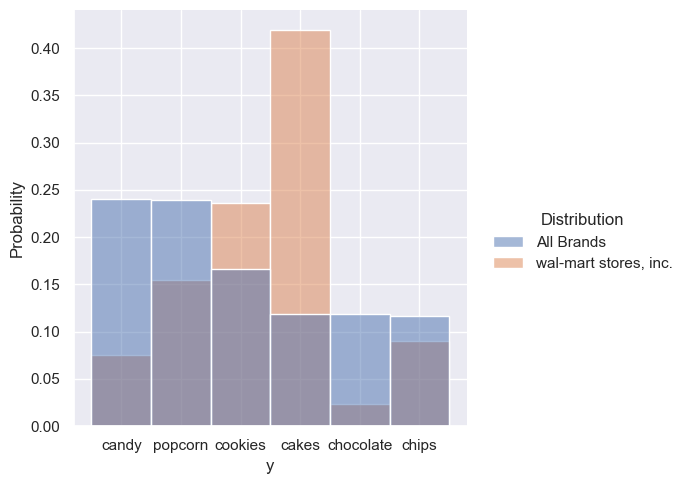

In [47]:
import seaborn as sns

most_frequesnt_brand = X_train["brand"].mode()[0]

categories_all_brands = pd.DataFrame(
    {
        "y": X_train["y"],
        "Distribution": "All Brands",
    }
)

categories_most_freq_brand = pd.DataFrame(
    {
        "y": X_train[X_train["brand"] == most_frequesnt_brand]["y"],
        "Distribution": most_frequesnt_brand,
    }
)

df_combined = pd.concat([categories_all_brands, categories_most_freq_brand])
df_combined["y"] = pd.Categorical(
    df_combined["y"], list(categories_all_brands["y"].value_counts().index)
)

sns.set_theme()
sns.displot(
    df_combined, x="y", hue="Distribution", stat="probability", common_norm=False
)

We will use Naive Bayes to compute the posterior distributions for each category, treating the brands as tokens.

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

sentences = X_train["brand"].str.replace(" ", "")
val_sentences = X_val["brand"].str.replace(" ", "")

# Step 1: Create the bag-of-words representation
vectorizer = CountVectorizer(ngram_range=(1, 1))
train_matrix = vectorizer.fit_transform(sentences)
val_matrix = vectorizer.transform(val_sentences)

# Step 2: Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(train_matrix, y_train)

# Step 3: Predict using the classifier
y_pred_nb = nb_classifier.predict(val_matrix)

# Step 4: Evaluation
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Classification Report:")
print(classification_report(y_val, y_pred_nb))

Accuracy: 0.6233466302750368
Classification Report:
              precision    recall  f1-score   support

       cakes       0.72      0.62      0.66       561
       candy       0.56      0.74      0.64      1128
       chips       0.81      0.48      0.60       533
   chocolate       0.74      0.51      0.61       556
     cookies       0.80      0.49      0.61       798
     popcorn       0.54      0.72      0.62      1187

    accuracy                           0.62      4763
   macro avg       0.69      0.59      0.62      4763
weighted avg       0.66      0.62      0.62      4763



62% accuracy just by using the brand! This simple algorithm achieved impressive accuracy in predicting the category based solely on the snack's brand.

However, it's important to note that the number of snacks per brand for a given category isn't very large, and there are many unique brands. This should be taken into account if we decide to vectorize the brand column.

## Description

The description column is particularly interesting because it contains a wealth of unstructured information about the food. We anticipate significantly better accuracy using the Naive Bayes approach. To vectorize the text, we employ CountVectorizer, incorporating useful features such as removing stop words, treating n-grams as single tokens, stripping accents, and removing non-alphanumeric characters, among others.

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

sentences = X_train["description"]
val_sentences = X_val["description"]

# Step 1: Create the bag-of-words representation
vectorizer = CountVectorizer(
    stop_words="english", ngram_range=(1, 6), strip_accents="unicode"
)
train_matrix = vectorizer.fit_transform(sentences)
val_matrix = vectorizer.transform(val_sentences)

# Step 2: Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(train_matrix, y_train)

# Step 3: Predict using the classifier
y_pred_nb = nb_classifier.predict(val_matrix)

# Step 4: Evaluation
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Classification Report:")
print(classification_report(y_val, y_pred_nb))

Accuracy: 0.9030023094688222
Classification Report:
              precision    recall  f1-score   support

       cakes       0.97      0.93      0.95       561
       candy       0.90      0.89      0.90      1128
       chips       0.96      0.94      0.95       533
   chocolate       0.73      0.80      0.77       556
     cookies       0.92      0.92      0.92       798
     popcorn       0.93      0.92      0.92      1187

    accuracy                           0.90      4763
   macro avg       0.90      0.90      0.90      4763
weighted avg       0.91      0.90      0.90      4763



Achieving 90% accuracy is impressive, given the simplicity of the model. However, the precision and recall for the chocolate category are noticeably lower than for other categories. Additionally, the F1 score for candy is concerning, especially since a significant portion of the snacks in our dataset are candies.

For each category, we will identify the most important words in the description column:

In [58]:
feature_names = vectorizer.get_feature_names_out()
class_names = [name.split("_")[0] for name in nb_classifier.classes_]
num_classes = len(class_names)

for i, class_name in enumerate(class_names):
    print(f"Most important words for class '{class_name}':")
    top_features_idx = nb_classifier.feature_log_prob_[i].argsort()[::-1][:10]
    top_features = [feature_names[idx] for idx in top_features_idx]
    print(", ".join(top_features), end="\n\n")

Most important words for class 'cakes':
cake, chocolate, pie, cupcakes, mini, cakes, creme, donuts, brownie, cheesecake

Most important words for class 'candy':
candy, chocolate, fruit, sour, gummi, jelly, milk, gummy, candies, chewy

Most important words for class 'chips':
chips, potato, potato chips, tortilla, tortilla chips, kettle, corn, salt, cooked, pretzels

Most important words for class 'chocolate':
chocolate, milk, dark, milk chocolate, dark chocolate, truffles, bar, caramel, chocolates, salt

Most important words for class 'cookies':
cookies, chocolate, cookie, chip, chocolate chip, sandwich, sugar, butter, wafers, creme

Most important words for class 'popcorn':
roasted, mix, almonds, popcorn, chocolate, peanuts, salted, trail, trail mix, cashews



The overlap between the most important words for each category is minimal, though not entirely absent. For instance, the word chocolate is significant for all categories except chips_pretzels_snacks. Words like creme, milk, and salt appear among the top 10 most important words for more than one category. We will now explore the range of important words and n-grams for each category, determining when they start to lose informativeness.

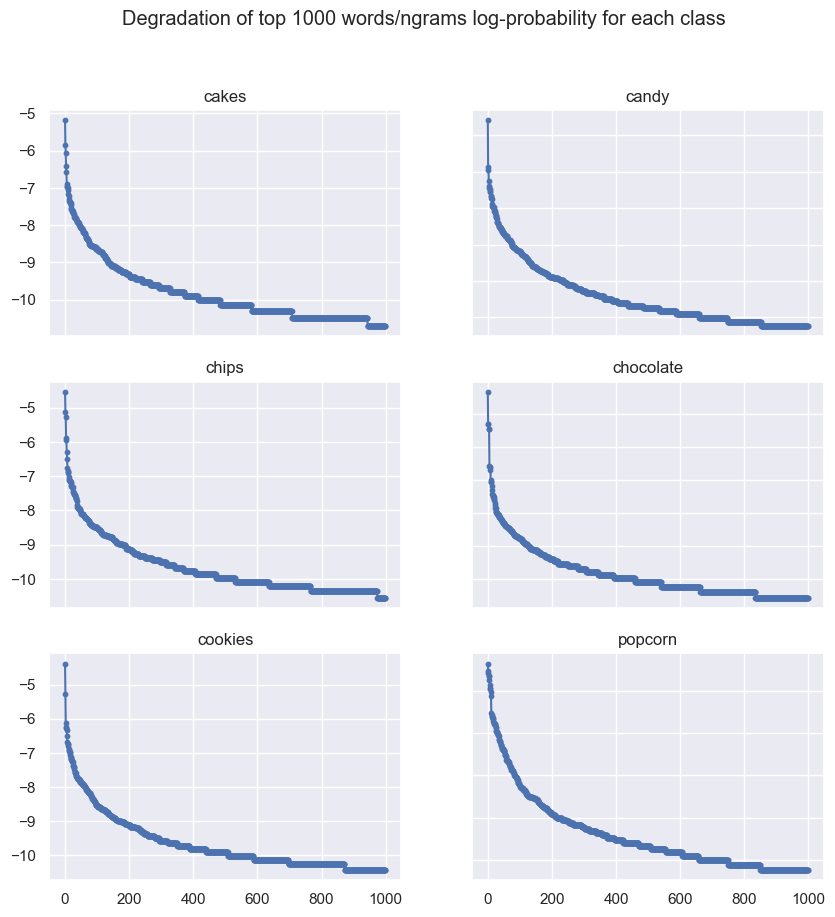

In [60]:
import matplotlib.pyplot as plt
import numpy as np


fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Degradation of top 1000 words/ngrams log-probability for each class")

for c in range(6):
    i, j = c // 2, c % 2
    axs[i, j].scatter(
        range(1000), np.sort(nb_classifier.feature_log_prob_[c])[-1000:][::-1], s=10
    )
    axs[i, j].plot(
        range(1000), np.sort(nb_classifier.feature_log_prob_[c])[-1000:][::-1]
    )
    axs[i, j].set_title(class_names[c])

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

With the wide variety of n-grams, the number of features could grow significantly. To start with a simpler model, I plan to replace the description and brand columns with six new columns—one for each category. Each column's value will represent the log-probability that the corresponding feature is associated with that category, as calculated by the Naive Bayes model.

Replacing `brand` and `description` with their Naive Bayes scores:


In [63]:
from helpers.preprocess import NaiveBayesScores

NaiveBayesScores(
    colname="brand", preprocess_func=lambda x: x.replace(" ", "")
).fit_transform(X=X_train, y=y_train)

NaiveBayesScores(
    colname="description",
    vectorizer_kwgs=dict(
        stop_words="english", ngram_range=(1, 6), strip_accents="unicode"
    ),
).fit_transform(X=X_train, y=y_train)

,idx,ingredients,serving_size,serving_size_unit,household_serving_fulltext,y,protein__(g),total_lipid_(fat)__(g),carbohydrate_by_difference__(g),energy__(kcal),...,brand_nb_score_chips,brand_nb_score_chocolate,brand_nb_score_cookies,brand_nb_score_popcorn,description_nb_score_cakes,description_nb_score_candy,description_nb_score_chips,description_nb_score_chocolate,description_nb_score_cookies,description_nb_score_popcorn
23212,25784,sugar bleached_wheat_flour soybean_oil,28.0,g,1 onz,cakes,3.57,21.43,60.71,464,...,-2.536376,-4.083942,-1.782971,-0.769932,-2.955858e-04,-9.946544,-1.905615e+01,-11.153186,-8.364468e+00,-14.975742
22158,24607,filling wheat_flour baking_powder,30.0,g,4 pieces,cookies,3.33,30.00,66.67,533,...,-2.655216,-2.620499,-0.524252,-2.361643,-9.864426e+00,-8.939836,-1.490225e+01,-10.779114,-2.043734e-04,-15.849332
1703,1898,enriched_wheat_flour water sugar,54.0,g,4 holes,cakes,5.56,22.22,48.15,407,...,-2.045440,-5.340313,-2.346195,-0.622098,-5.684342e-14,-38.317800,-3.704711e+01,-35.202871,-3.078935e+01,-34.671889
20886,23191,sugar_wheat_flour_nonfat_milk_cocoa_butter_cho...,42.0,g,1 four-piece bar,candy,7.14,26.19,64.29,500,...,-5.331526,-5.111576,-5.439135,-3.481568,-1.893499e+01,-0.475797,-2.609830e+01,-1.015086,-4.120400e+00,-14.198123
18703,20739,sugar enriched_bleached_flour vegitable_shorening,67.0,g,2 cakes/1 pkg,cakes,2.99,13.43,65.67,403,...,-4.669234,-4.634516,-2.874742,-4.375660,-3.836931e-12,-28.661906,-3.243408e+01,-27.093615,-2.707072e+01,-32.675462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,33105,sugar enriched_wheat_flour_bleached vegetable_oil,85.0,g,3 onz,cakes,3.53,21.18,55.29,424,...,-3.260487,-3.631234,-1.689139,-0.887471,-2.452065e-04,-9.989179,-2.056641e+01,-10.494364,-8.687072e+00,-12.773131
5390,6019,sugar enriched_bleached_wheat_flour margarine,38.0,g,1 cookie,cookies,2.63,13.16,65.79,395,...,-2.386696,-4.125424,-3.350340,-0.916953,-2.756156e+01,-34.492868,-3.967875e+01,-37.524420,-1.080025e-12,-37.188134
860,960,corn line_and_corn_oil,39.0,g,1.4 onz,chips,5.13,23.08,66.67,487,...,-1.099541,-2.163436,-2.013100,-1.904580,-2.307783e+01,-22.299619,-1.962732e-09,-22.797426,-2.048519e+01,-22.045293
15795,17524,sunflower_seeds almonds date_sugar,28.0,g,0.25 cup,cookies,14.29,25.00,25.00,357,...,-2.532322,-2.491713,-1.797598,-1.035861,-4.621251e+00,-4.138648,-3.092892e+00,-4.000533,-5.547572e-01,-1.089671


In [64]:
X_train[[f"{brand}_nb_score_chocolate" for brand in ["brand", "description"]]].head()

,brand_nb_score_chocolate,description_nb_score_chocolate
23212,-4.083942,-11.153186
22158,-2.620499,-10.779114
1703,-5.340313,-35.202871
20886,-5.111576,-1.015086
18703,-4.634516,-27.093615


In [65]:
X_train.iloc[:2, -6:] # description scores
np.exp(X_train.iloc[:2, -6:]).sum(axis=1) # probabilities sum to 1

23212    1.0
22158    1.0
dtype: float64

Ultimately, I plan to experiment with ensemble-based models using the raw vectorized features to see if we can surpass the accuracy achieved with the Naive Bayes score features.

## Serving Size Unit


In [66]:
X_train["serving_size_unit"].value_counts()

g     25392
ml        8
Name: serving_size_unit, dtype: int64

In [67]:
X_train[X_train["serving_size_unit"] == "ml"]["y"]


11626    candy
12633    candy
19728    cakes
21321    candy
25726    candy
9445     candy
8554     candy
23010    candy
Name: y, dtype: object

Not a very informative column, as \>99.9% of the data is `g`. We'll drop this column.


In [68]:
from helpers.preprocess import DropColumns

DropColumns(columns=["serving_size_unit"]).fit_transform(X=X_train)

,idx,ingredients,serving_size,household_serving_fulltext,y,protein__(g),total_lipid_(fat)__(g),carbohydrate_by_difference__(g),energy__(kcal),starch__(g),...,brand_nb_score_chips,brand_nb_score_chocolate,brand_nb_score_cookies,brand_nb_score_popcorn,description_nb_score_cakes,description_nb_score_candy,description_nb_score_chips,description_nb_score_chocolate,description_nb_score_cookies,description_nb_score_popcorn
23212,25784,sugar bleached_wheat_flour soybean_oil,28.0,1 onz,cakes,3.57,21.43,60.71,464,0.0,...,-2.536376,-4.083942,-1.782971,-0.769932,-2.955858e-04,-9.946544,-1.905615e+01,-11.153186,-8.364468e+00,-14.975742
22158,24607,filling wheat_flour baking_powder,30.0,4 pieces,cookies,3.33,30.00,66.67,533,0.0,...,-2.655216,-2.620499,-0.524252,-2.361643,-9.864426e+00,-8.939836,-1.490225e+01,-10.779114,-2.043734e-04,-15.849332
1703,1898,enriched_wheat_flour water sugar,54.0,4 holes,cakes,5.56,22.22,48.15,407,0.0,...,-2.045440,-5.340313,-2.346195,-0.622098,-5.684342e-14,-38.317800,-3.704711e+01,-35.202871,-3.078935e+01,-34.671889
20886,23191,sugar_wheat_flour_nonfat_milk_cocoa_butter_cho...,42.0,1 four-piece bar,candy,7.14,26.19,64.29,500,0.0,...,-5.331526,-5.111576,-5.439135,-3.481568,-1.893499e+01,-0.475797,-2.609830e+01,-1.015086,-4.120400e+00,-14.198123
18703,20739,sugar enriched_bleached_flour vegitable_shorening,67.0,2 cakes/1 pkg,cakes,2.99,13.43,65.67,403,0.0,...,-4.669234,-4.634516,-2.874742,-4.375660,-3.836931e-12,-28.661906,-3.243408e+01,-27.093615,-2.707072e+01,-32.675462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,33105,sugar enriched_wheat_flour_bleached vegetable_oil,85.0,3 onz,cakes,3.53,21.18,55.29,424,0.0,...,-3.260487,-3.631234,-1.689139,-0.887471,-2.452065e-04,-9.989179,-2.056641e+01,-10.494364,-8.687072e+00,-12.773131
5390,6019,sugar enriched_bleached_wheat_flour margarine,38.0,1 cookie,cookies,2.63,13.16,65.79,395,0.0,...,-2.386696,-4.125424,-3.350340,-0.916953,-2.756156e+01,-34.492868,-3.967875e+01,-37.524420,-1.080025e-12,-37.188134
860,960,corn line_and_corn_oil,39.0,1.4 onz,chips,5.13,23.08,66.67,487,0.0,...,-1.099541,-2.163436,-2.013100,-1.904580,-2.307783e+01,-22.299619,-1.962732e-09,-22.797426,-2.048519e+01,-22.045293
15795,17524,sunflower_seeds almonds date_sugar,28.0,0.25 cup,cookies,14.29,25.00,25.00,357,0.0,...,-2.532322,-2.491713,-1.797598,-1.035861,-4.621251e+00,-4.138648,-3.092892e+00,-4.000533,-5.547572e-01,-1.089671


## Serving Size


First, we'll take a look at the distribution of the serving size per category:

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'Log Serving size')]

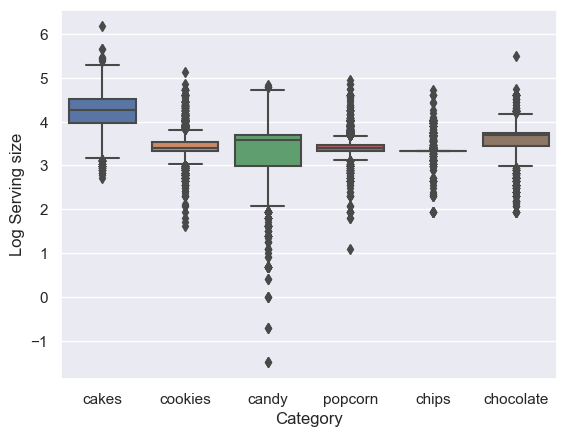

In [69]:
import seaborn as sns

ax = sns.boxplot(
    x=X_train["y"].apply(lambda x: x.split("_")[0]), y=np.log(X_train["serving_size"])
)
ax.set(xlabel="Category", ylabel="Log Serving size")

It’s hard to gauge how helpful this column is, as the distribution is somewhat similar across several categories. However, there are some useful patterns, such as smaller serving sizes likely indicating candy, and there may be more insights like this. Since this column is 'cheap' for the model—it’s numeric with no missing values—we’ll keep it for now, applying a log transformation first.

In [70]:
from helpers.preprocess import LogTransformation

LogTransformation(columns=["serving_size"]).fit_transform(X=X_train)

,idx,ingredients,serving_size,household_serving_fulltext,y,protein__(g),total_lipid_(fat)__(g),carbohydrate_by_difference__(g),energy__(kcal),starch__(g),...,brand_nb_score_chips,brand_nb_score_chocolate,brand_nb_score_cookies,brand_nb_score_popcorn,description_nb_score_cakes,description_nb_score_candy,description_nb_score_chips,description_nb_score_chocolate,description_nb_score_cookies,description_nb_score_popcorn
23212,25784,sugar bleached_wheat_flour soybean_oil,3.332205,1 onz,cakes,3.57,21.43,60.71,464,0.0,...,-2.536376,-4.083942,-1.782971,-0.769932,-2.955858e-04,-9.946544,-1.905615e+01,-11.153186,-8.364468e+00,-14.975742
22158,24607,filling wheat_flour baking_powder,3.401197,4 pieces,cookies,3.33,30.00,66.67,533,0.0,...,-2.655216,-2.620499,-0.524252,-2.361643,-9.864426e+00,-8.939836,-1.490225e+01,-10.779114,-2.043734e-04,-15.849332
1703,1898,enriched_wheat_flour water sugar,3.988984,4 holes,cakes,5.56,22.22,48.15,407,0.0,...,-2.045440,-5.340313,-2.346195,-0.622098,-5.684342e-14,-38.317800,-3.704711e+01,-35.202871,-3.078935e+01,-34.671889
20886,23191,sugar_wheat_flour_nonfat_milk_cocoa_butter_cho...,3.737670,1 four-piece bar,candy,7.14,26.19,64.29,500,0.0,...,-5.331526,-5.111576,-5.439135,-3.481568,-1.893499e+01,-0.475797,-2.609830e+01,-1.015086,-4.120400e+00,-14.198123
18703,20739,sugar enriched_bleached_flour vegitable_shorening,4.204693,2 cakes/1 pkg,cakes,2.99,13.43,65.67,403,0.0,...,-4.669234,-4.634516,-2.874742,-4.375660,-3.836931e-12,-28.661906,-3.243408e+01,-27.093615,-2.707072e+01,-32.675462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,33105,sugar enriched_wheat_flour_bleached vegetable_oil,4.442651,3 onz,cakes,3.53,21.18,55.29,424,0.0,...,-3.260487,-3.631234,-1.689139,-0.887471,-2.452065e-04,-9.989179,-2.056641e+01,-10.494364,-8.687072e+00,-12.773131
5390,6019,sugar enriched_bleached_wheat_flour margarine,3.637586,1 cookie,cookies,2.63,13.16,65.79,395,0.0,...,-2.386696,-4.125424,-3.350340,-0.916953,-2.756156e+01,-34.492868,-3.967875e+01,-37.524420,-1.080025e-12,-37.188134
860,960,corn line_and_corn_oil,3.663562,1.4 onz,chips,5.13,23.08,66.67,487,0.0,...,-1.099541,-2.163436,-2.013100,-1.904580,-2.307783e+01,-22.299619,-1.962732e-09,-22.797426,-2.048519e+01,-22.045293
15795,17524,sunflower_seeds almonds date_sugar,3.332205,0.25 cup,cookies,14.29,25.00,25.00,357,0.0,...,-2.532322,-2.491713,-1.797598,-1.035861,-4.621251e+00,-4.138648,-3.092892e+00,-4.000533,-5.547572e-01,-1.089671


### Images Dataset

We used ResNet18 as a fixed feature extractor to evaluate its effectiveness in predicting categories by applying a linear classifier on the extracted image features (ResNet18: 
𝑅
224
×
224
→
𝑅
1000
R 
224×224
 →R 
1000
 ), following the guidelines of PyTorch tutorial. Due to the large size of the extracted feature files (300 MB), we’re sharing only the results here, though code blocks remain in the RMD file to demonstrate the process. With ResNet18 frozen and Logistic Regression applied to the output layer, we achieved 52% accuracy—significantly above random chance—without adjusting any original network weights. Next, we’ll fine-tune ResNet18 and incorporate score features as additional columns. ResNet code is available in resnet.py.